In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns # get more colormaps
plt.style.use("bioAI.mplstyle")
import torch
import scipy
import umap as umap
from ripser import ripser
from persim import plot_diagrams
import tqdm

import sys
sys.path.append('../')
from methods import *
from models import JacobianCI, JitterCI
from plotting_functions import set_size, project_cmap, minimal_ticks, scatter3d

import umap.umap_ as umap


In [ ]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [38]:
N = np.arange(7,147,7)
A = np.linspace(0.1,2,20)
N_grid, A_grid = np.meshgrid(N,A)

sigma_hex = 3*(np.pi**2)*(A_grid**2)*N_grid
sigma_square = 2*(np.pi**2)*(A_grid**2)*N_grid
vmin = min(sigma_hex.min(), sigma_square.min())
vmax = max(sigma_hex.max(), sigma_square.max())

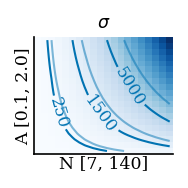

In [128]:
figsize=set_size(fraction=(1/4,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize)
c = ax.pcolormesh(N_grid, A_grid, sigma_hex.T,vmin=vmin,vmax=vmax)
cs = ax.contour(N_grid,A_grid,sigma_hex.T,levels=[250,1500,5000],colors=color_cycle[0],alpha=1)
ax.clabel(cs, inline=True, fontsize=8)
ax.contour(N_grid,A_grid,sigma_square.T,levels=[250,1500,5000],colors=color_cycle[0],alpha=0.5)
#ax.set_xlabel('N')
#ax.set_ylabel('A',rotation=0)

ax.set_xlabel(r'N [{}, {}]'.format(np.min(N),np.max(N)),fontsize='small')
ax.set_xticks([])
ax.set_ylabel('A [{}, {}]'.format(np.min(A), np.max(A)),fontsize='small')
ax.set_yticks([])
ax.set_title(r'$\sigma$',fontsize='small')

fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
fig.savefig('../results/F4-P1_hex_scale')

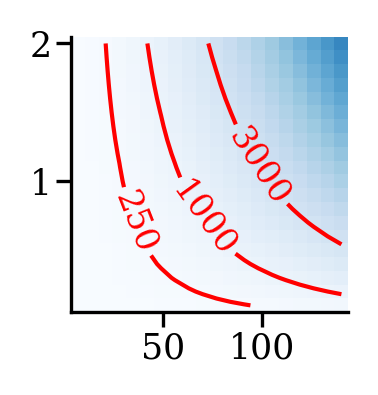

In [48]:
figsize=set_size(fraction=(1/4,1/4),mode='square')
fig, ax = plt.subplots(1,1,figsize=figsize,dpi=300)
c = ax.pcolormesh(N_grid, A_grid, sigma_square.T,vmin=vmin,vmax=vmax)
#plt.colorbar(c)
cs = ax.contour(N_grid,A_grid,sigma_square.T,levels=[250,1000,3000],colors='red')
ax.clabel(cs, inline=True, fontsize=8)
#ax.set_xlabel('N')
#ax.set_ylabel('A',rotation=0)
#fig.savefig('../results/F4-P1_hex_scale.png',dpi=300)

In [81]:
energy = np.zeros([len(A),len(N)])
energy_variances = np.zeros([len(A),len(N)])
res = 100
nsamples_space = 2**8
rs = model.unit_cell.mesh(res)

for c2, n in enumerate(N):
    model = JacobianCI(ncells=n,lr=1e-3, shift=0, p_magnitude=0)
    for epoch in tqdm.trange(1500):
        r_samples = model.unit_cell.sample(nsamples_space)
        r_samples = torch.tensor(r_samples,dtype=torch.float32)
        loss_CI = model.train_step(r_samples)
    for c1, a in enumerate(A):
        activity = a*model.forward(torch.Tensor(rs)).detach().numpy()
        energy[c1,c2] = np.mean(np.linalg.norm(activity,axis=1))
        energy_variances[c1,c2] = np.var(np.linalg.norm(activity,axis=1))

100%|██████████| 1500/1500 [00:05<00:00, 289.06it/s]


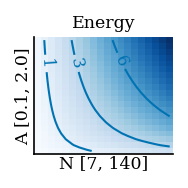

In [127]:
figsize=set_size(fraction=(1/4,1/4),mode='square')
fig, ax = plt.subplots(figsize=figsize)
c = ax.pcolormesh(N_grid, A_grid, energy.T)
cs = ax.contour(N_grid,A_grid,energy.T,levels=[1,3,6],colors=color_cycle[0],alpha=1)
ax.clabel(cs, inline=True, fontsize=8)
#ax.set_xlabel('N')
#ax.set_ylabel('A',rotation=0)

ax.set_xlabel(r'N [{}, {}]'.format(np.min(N),np.max(N)),fontsize='small')
ax.set_xticks([])
ax.set_ylabel('A [{}, {}]'.format(np.min(A), np.max(A)),fontsize='small')
ax.set_yticks([])
ax.set_title('Energy',fontsize='small')


fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
fig.savefig('../results/F4-P1_energy')

In [96]:
model = JacobianCI(ncells=133,lr=1e-3, shift=0, p_magnitude=0)
activity = a*model.forward(torch.Tensor(rs)).detach().numpy()
np.var(np.linalg.norm(activity,axis=1))

0.43254867

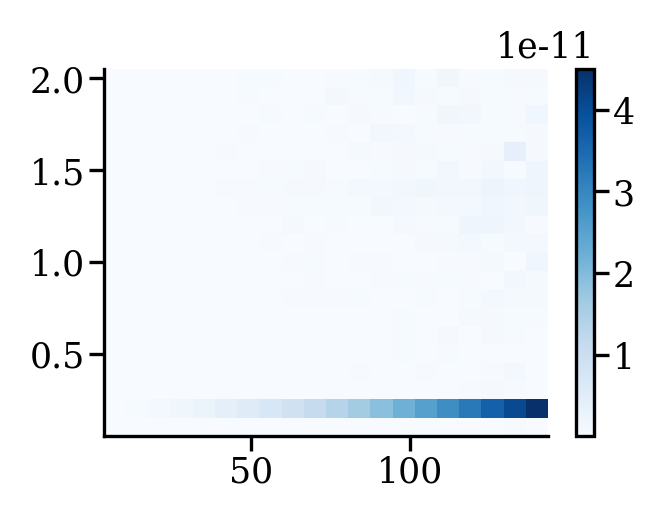

In [91]:
# CHECK VARIANCE OF ENERGY
figsize=set_size(fraction=(1/2,1/3),mode='square')
fig, ax = plt.subplots(1,1,figsize=figsize,dpi=300)
c = ax.pcolormesh(N_grid, A_grid, energy_variances.T)
plt.colorbar(c)
#fig.savefig('./F4-P1_energy.pdf')

In [178]:
#Torus scale 

model_small = JacobianCI(ncells=10,lr=1e-3, shift=0, p_magnitude=0)
model_big = JacobianCI(ncells=100,lr=1e-3, shift=0, p_magnitude=0)

rs = model.unit_cell.mesh(res)
nsamples_space = 2**8
for epoch in tqdm.trange(4000):
    r_samples = model_small.unit_cell.sample(nsamples_space)
    r_samples = torch.tensor(r_samples,dtype=torch.float32)
    loss_CI_small = model_small.train_step(r_samples)
    loss_CI_big = model_big.train_step(r_samples)



100%|██████████████████████████████████████| 4000/4000 [00:13<00:00, 287.72it/s]


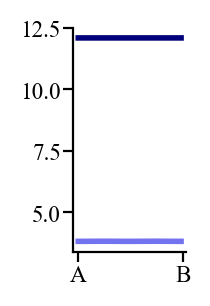

In [217]:
#parametrized curve
curve = np.array([(np.sqrt(3)/2)*np.linspace(-0.58,0.58,100),0.5*np.linspace(-0.58,0.58,100)]).T
curve_deriv = np.linalg.norm(curve[1:]-curve[:-1],axis=1)[0]
activity_small = model_small.forward(torch.Tensor(curve)).detach().numpy()
activity_big = model_big.forward(torch.Tensor(curve)).detach().numpy()

deriv_small = np.linalg.norm((activity_small[1:]-activity_small[:-1])/curve_deriv,axis=1)
deriv_big = np.linalg.norm((activity_big[1:]-activity_big[:-1])/curve_deriv,axis=1)

figsize=set_size(fraction=(2/9,1/3),mode='square')
fig, ax = plt.subplots(1,1,figsize=figsize,dpi=200)
ax.plot(deriv_small,color='#7373efff',lw=2)
ax.plot(deriv_big,color='#00007bff', lw=2)
ax.set_xticks([0,100],['A','B'])
#ax.set_ylabel('$||\Delta g(\gamma(t))||$')
#ax.set_xlabel('$t$')
fig.tight_layout()
fig.savefig('./F4-P3_resolution_nolab.pdf',dpi=300)